# This Notebook Loads Data into MongoDB, a local mySQL Server, and finds one of those tables from the Local Filesystem

1. There will be a separate Azure notebook that accomplishes the data streaming (Bronze, Silver, Gold) and creates the fact table.
2. The dataset was sourced from https://www.kaggle.com/datasets/benten867/cannabis-data?select=consumer+and+producer.csv

In [56]:
import os
from sqlalchemy import text, create_engine
import pandas as pd
import json
import datetime
import pymongo
import requests

#Import for displaying images at the end of the notebook
from IPython.display import Image

#For loading data from amazon s3, must also have s3fs and fsspec installed 
import boto3
import aws_access

In [57]:
#allows pd to show more columns when printing head
pd.set_option('display.max_columns', 500)

#sets up aws environment variables for data loading:
aws_access.setupAWS()

## Connection String Creation:

In [33]:
#SQL:
host_name = "wfl9zymysql.mysql.database.azure.com" # the host name
user_id = "wloving77" # the user id of the account
pwd = os.environ["PWD"] # an enviornmental variable invisible as I delete the cell after creating it. 
db_name = "ds2002-Midterm2"

conn_str_sql = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"



In [42]:
#MongoDB:
atlas_cluster_name = "dscluster"
atlas_user_name = "wloving77"
atlas_password = os.environ["PWD"] # omitted the cell defining this variable for password security. 
atlas_special_key = "iynrpaa"

db_name_mongo = "ds2002-Midterm2"


conn_str_mongo = f"mongodb+srv://{atlas_user_name}:{atlas_password}@{atlas_cluster_name}.{atlas_special_key}.mongodb.net"


## Functions For Moving Data To/From SQL and MongoDB

1. SQL: set_dataframe
2. MongoDB: set_collection

In [5]:
#Function for creating a table on a SQL server
def set_dataframe(conn_str, df, table_name, db_name, db_operation):
    
    '''Create a connection to SQL'''
    sqlEngine = create_engine(conn_str, pool_recycle=360)
    connection = sqlEngine.connect()
        
    if db_operation == "insert":
        df.to_sql(table_name, schema = db_name, con = sqlEngine, index=False, if_exists='replace')
            
    elif db_operation == "update":
        df.to_sql(table_name, schema=db_name,con=connection, index=False, if_exists='append')
    
    connection.close()

In [40]:
#My function that sets a mongodb collection to be the provided dataframe
def set_mongo_dataframe(connection_str, df, db_name, collection):
        client = pymongo.MongoClient(connection_str)
        db = client[db_name]
        db[collection].insert_many(df.to_dict('records'))
        client.close()

## Load Data Into Both Azure SQL Server and MongoDB Atlas
- All Data Was Downloaded Locally and Was Moved from The Local Fileystem to Azure and Mongo
- The Steps are as follows:
1. Load 5 csv's into 5 dataframes
2. Load those 5 dataframes into an SQL Server hosted on Azure
3. Load those same 5 dataframes into a MongoDB Cluster. 

In [70]:
s3_bucket_name = 'ds2002-midterm'

s3_key1 = "consumer_and_producer.csv"
s3_key2 = "income.csv"
s3_key3 = "industry_production.csv"
s3_key4 = "licensed_industry_stats.csv"
s3_key5 = "supply.csv"

s3_string1 = f's3://{s3_bucket_name}/{s3_key1}'
s3_string2 = f's3://{s3_bucket_name}/{s3_key2}'
s3_string3 = f's3://{s3_bucket_name}/{s3_key3}'
s3_string4 = f's3://{s3_bucket_name}/{s3_key4}'
s3_string5 = f's3://{s3_bucket_name}/{s3_key5}'

In [71]:
df_consumer_and_producer = pd.read_csv(s3_string1)
df_income = pd.read_csv(s3_string2)
df_industry_production = pd.read_csv(s3_string3)
df_licensed_industry_stats = pd.read_csv(s3_string4)
df_supply = pd.read_csv(s3_string5)

## Proof Data Exists:

In [13]:
df_consumer_and_producer.head(2)

,REF_DATE,GEO,DGUID,Cannabis price,Units of measure,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961,Canada,2016A000011124,Consumer price,Price per gram,Dollars,81,units,0,v1001799937,1.1.1,4.39,NaN,NaN,NaN,2
1,1961,Canada,2016A000011124,Consumer price,Price index,2012=100,383,units,0,v1001799938,1.1.2,50.30,NaN,NaN,NaN,1


In [14]:
df_income.head(2)

,REF_DATE,GEO,DGUID,Estimate,Industry,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961,Canada,2016A000011124,Gross domestic product (GDP),Medical cannabis industry,Dollars,81,millions,6,v1001809219,1.1.1,0,NaN,NaN,NaN,0
1,1961,Canada,2016A000011124,Gross domestic product (GDP),Non-medical cannabis industry,Dollars,81,millions,6,v1001809224,1.1.2,94,NaN,NaN,NaN,0


In [15]:
df_industry_production.head(2)

,REF_DATE,GEO,DGUID,Indicator,Industry,Authority,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961,Canada,2016A000011124,Domestic production,Cannabis cultivation industry,Licensed source,Dollars,81,millions,6,v1001808807,1.1.1.1,0.0,NaN,NaN,NaN,0
1,1961,Canada,2016A000011124,Domestic production,Cannabis cultivation industry,Unlicensed source,Dollars,81,millions,6,v1001808808,1.1.1.2,83.0,NaN,NaN,NaN,0


In [16]:
df_licensed_industry_stats.head(2)

,REF_DATE,GEO,DGUID,Indicator,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016,Canada,2016A000011124,Total revenue,Dollars,81,units,0,v1001849328,1.1,245732000.0,NaN,NaN,NaN,0
1,2016,Canada,2016A000011124,Cannabis revenue,Dollars,81,units,0,v1001849329,1.2,239363000.0,NaN,NaN,NaN,0


In [17]:
df_supply.head(2)

,REF_DATE,GEO,DGUID,Indicator,Type of use,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1961,Canada,2016A000011124,Total supply,Medical use,Dollars,81,millions,6,v1001809167,1.1.1,0,NaN,NaN,NaN,0
1,1961,Canada,2016A000011124,Total supply,Non-medical use,Dollars,81,millions,6,v1001809179,1.1.2,190,NaN,NaN,NaN,0


## Now To Load The Dataframes to MongoDB and Azure SQL Server
- SQL:

In [34]:
#First I have to create the database for the data to be put in
sqlEngine = create_engine(conn_str_sql, pool_recycle=3600)

conn = sqlEngine.connect()

conn.execute(text("DROP DATABASE IF EXISTS `ds2002-Midterm2`;"))
conn.execute(text("CREATE DATABASE `ds2002-Midterm2`;"))

conn.close()

In [38]:
#Sends the dataframes to be created as tables on the SQL server
set_dataframe(conn_str_sql, df_consumer_and_producer, "consumer_and_producer", "insert")
set_dataframe(conn_str_sql, df_income, "income", "insert")
set_dataframe(conn_str_sql, df_industry_production, "industry_production", "insert")
set_dataframe(conn_str_sql, df_licensed_industry_stats, "licensed_industry_stats", "insert")
set_dataframe(conn_str_sql, df_supply, "supply", "insert")

- MongoDB:

In [73]:
client = pymongo.MongoClient(conn_str_mongo)
client.drop_database('ds2002-Midterm2')

In [74]:
#Sends the dataframes to be created as tables in a MongoDB cluster
set_mongo_dataframe(conn_str_mongo, df_consumer_and_producer, db_name_mongo, "consumer_and_producer")
set_mongo_dataframe(conn_str_mongo, df_income, db_name_mongo, "income")
set_mongo_dataframe(conn_str_mongo, df_industry_production, db_name_mongo, "industry_production")
set_mongo_dataframe(conn_str_mongo, df_licensed_industry_stats, db_name_mongo, "licensed_industry_stats")
set_mongo_dataframe(conn_str_mongo, df_supply, db_name_mongo, "supply")

## Proof of Successful Data Movement:

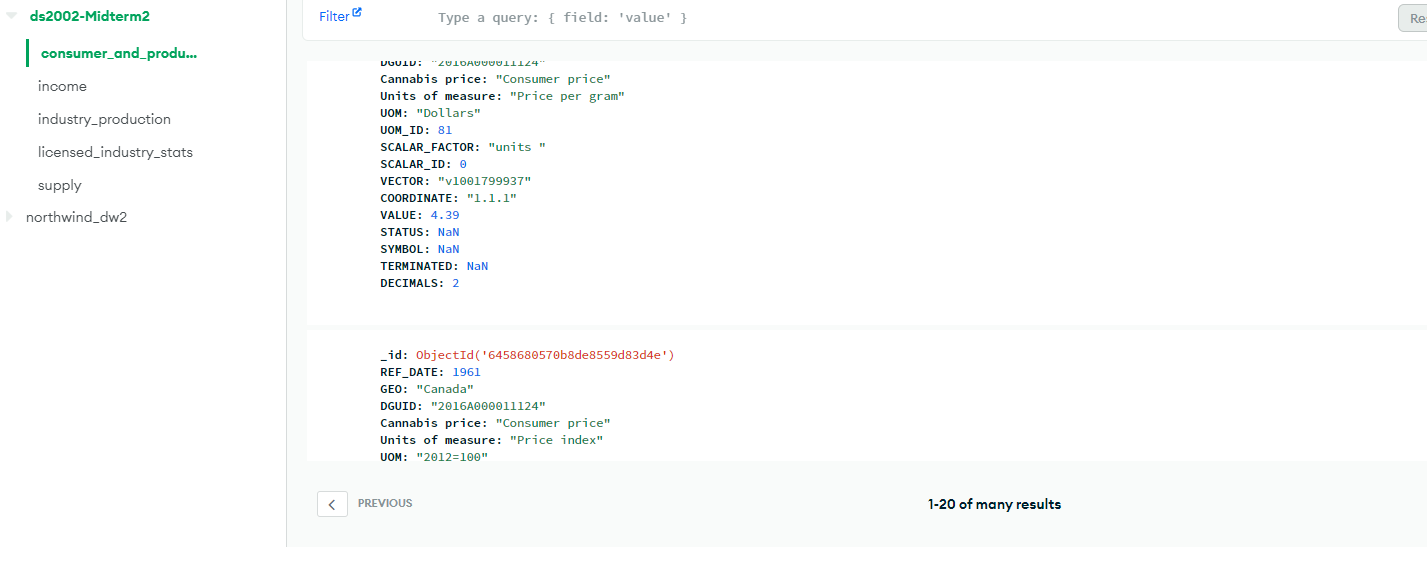

In [46]:
Image(filename='mongoProof-MT2.png') 

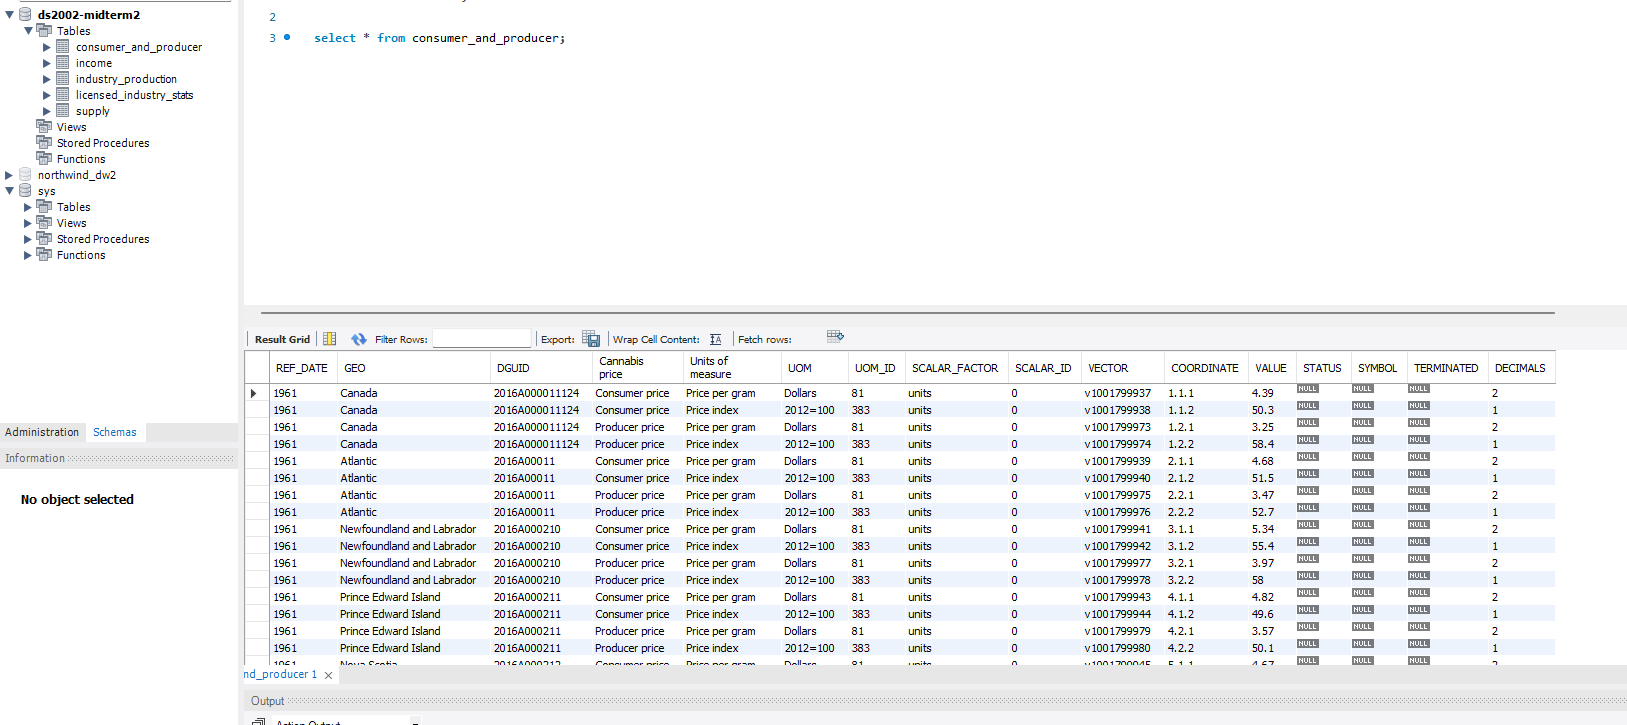

In [47]:
Image(filename = "sqlProof-MT2.png")